In [1]:
from compute_filters import *
from matplotlib import pyplot as plt

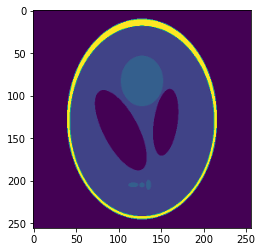

In [2]:
# create phantom
sl = tomopy.misc.phantom.shepp2d(size=256)[0]
plt.imshow(sl)

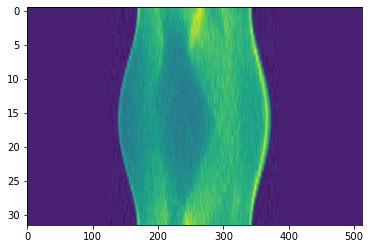

In [3]:
# create data using ASTRA
N = sl.shape[0]
N_theta = 32
angles = np.linspace(0,np.pi, N_theta, False)
vol_geom = astra.create_vol_geom(N,N)
proj_geom = astra.create_proj_geom('parallel', 1.0, N, angles)
proj_id = astra.create_projector('strip', proj_geom, vol_geom)
sino_id, sino = astra.create_sino(sl, proj_id)

# add noise to sino
sino = astra.add_noise_to_sino(sino,2**10)

# pad sinogram
sino = np.pad(sino, ((0,), (128,)), 'constant')

plt.imshow(sino, aspect='auto')

In [4]:
# reconstruct this sinogram with various software packages and the Shepp-Logan filter

recos = Reconstructions(sino, N, angles, filter='shepp-logan')

reco_strip = recos.astra_fbp()
reco_line = recos.astra_fbp(proj_type='line')
reco_linear = recos.astra_fbp(proj_type='linear')
# reco_cuda = recos.astra_fbp_cuda()
reco_iradon = recos.skimage_iradon()
reco_tomopy_gr = recos.tomopy_gridrec()

Reconstructing 1 slice groups with 1 master threads...


In [5]:
# compute implementation-adapted filters for each implementation and reconstruct using these filters

filters = ComputedFilters(sino, angles, N, exp_binning=True, large_bins=4)

strip = filters.filter_fbp('astra-strip')
line = filters.filter_fbp('astra-line')
linear = filters.filter_fbp('astra-linear')
# cuda = filters.filter_fbp('astra-cuda')
iradon = filters.filter_fbp('iradon')
tomopy_gr = filters.filter_fbp('tomopy-gridrec')
tomopy_gr[0] = 0.0 # this is required because the 0th component is zeroed out in tomopy

reco_filter_strip = fbp_with_filter(sino, angles, N, 'astra-strip', strip, circle=True)
reco_filter_line = fbp_with_filter(sino, angles, N, 'astra-line', line, circle=True)
reco_filter_linear = fbp_with_filter(sino, angles, N, 'astra-linear', linear, circle=True)
# reco_filter_cuda = fbp_with_filter(sino, angles, N, 'astra-cuda', cuda, circle=True)
reco_filter_iradon = fbp_with_filter(sino, angles, N, 'iradon', iradon, circle=True) 
reco_filter_tomopy_gr = gridrec_with_filter(sino, angles, N, 'tomopy-gridrec', tomopy_gr, circle=True)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...

Reconstructing 1 slice groups with 1 master threads...


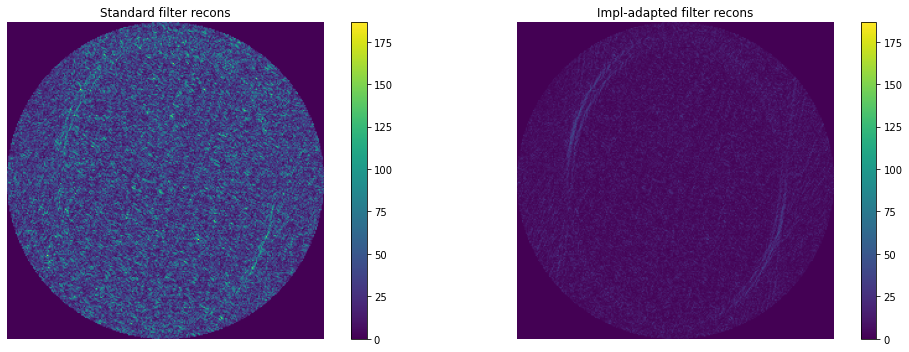

In [6]:
# compute standard deviation between sets of reconstructions and display these as heat maps

## standard reconstructions
std_reco = np.std([reco_strip.flatten(), 
                   reco_line.flatten(), 
                   reco_linear.flatten(),
#                    reco_cuda.flatten(), 
                   reco_iradon.flatten(), 
                   reco_tomopy_gr.flatten()], axis=0).reshape([N,N])

## implementaion-adapted reconstructions
std_reco_filter = np.std([reco_filter_strip.flatten(), 
                          reco_filter_line.flatten(), 
                          reco_filter_linear.flatten(),
#                           reco_filter_cuda.flatten(), 
                          reco_filter_iradon.flatten(), 
                          reco_filter_tomopy_gr.flatten()], axis=0).reshape([N,N])

_min = 0.0
_max = np.max(std_reco)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(std_reco, vmin=_min, vmax=_max)
plt.axis('off')
plt.colorbar()
plt.title('Standard filter recons')
plt.subplot(122)
plt.imshow(std_reco_filter, vmin=_min, vmax=_max)
plt.axis('off')
plt.colorbar()
plt.title('Impl-adapted filter recons')
plt.tight_layout()